# <b> <center> <font color='blue'> YATCH HYDRODINAMICS </font> </color> </b>

## Table of Contents

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Data Loading, Exploration and Pre-processing](#4)
5. [Build, compile and train the model](#5)
6. [Model Evaluation](#6)


## <b> <font color='#21618C'> 1. Problem Statement </font> </color>

Prediction of residuary resistance of sailing yachts at the initial design stage is of a great value for evaluating the shipâ€™s performance and for estimating the required propulsive power. Essential inputs include the basic hull dimensions and the boat velocity. 

https://archive.ics.uci.edu/dataset/243/yacht+hydrodynamics


This is a regression problem.

<a name="2"></a>
## <b> <font color='#21618C'> 2. Modules </font> </color>

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


<a name="3"></a>
## <b> <font color='#21618C'> 3. Helper Functions </font> </color>

In [69]:
# plotting utilities


def history_plot(histo):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


def scatter_plots(dataframe):
    # Set the style for seaborn plots
    sns.set(style="ticks")

    # Calculate the number of rows needed based on the number of features
    num_features = len(df.columns) - 1  # Exclude the last column which is the label
    num_rows = (num_features + 2) // 3  # Add 2 to ensure that we round up

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each feature and create a scatter plot against the label
    for i, feature in enumerate(df.columns[:-1]):  # Exclude the last column which is the label
        sns.scatterplot(x=feature, y=df.columns[-1], data=df, ax=axes[i])
        axes[i].set_title(f"Scatter Plot of {feature} vs Label")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(df.columns[-1])

    # Hide the remaining empty subplots
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()



<a name="4"></a>
## <b> <font color='#21618C'> 4. Data Loading, Exploration, and Pre-processing </font> </color>

### Loading data

The data was downloaded from the following URL and saved in a folder named "data"

In [9]:
! ls data

yacht_hydrodynamics.data


Gerritsma,J., Onnink,R., and Versluis,A.. (2013). Yacht Hydrodynamics. UCI Machine Learning Repository. https://doi.org/10.24432/C5XG7R.

In [65]:
# loading data

# Open the .data file in read mode
with open('data/yacht_hydrodynamics.data', 'r') as file:
    # Initialize lists to store features and labels
    features = []
    labels = []

    # Read all lines from the file
    lines = file.readlines()

    # Iterate through each line
    for line in lines:
        # Split the line into individual data elements using spaces as separators
        data_elements = line.split()

        # Check if the line has at least seven elements
        if len(data_elements) >= 7:
            # Extract the first six elements as features and the seventh element as the label
            features.append(data_elements[:6])  # Save the first six variables as features
            labels.append(data_elements[6])      # Save the seventh variable as the label

# Now you have 'features' containing the first six variables for each data point
# And 'labels' containing the seventh variable (label) for each data point



In [66]:
type(features), type(labels)

(list, list)

### Visualization

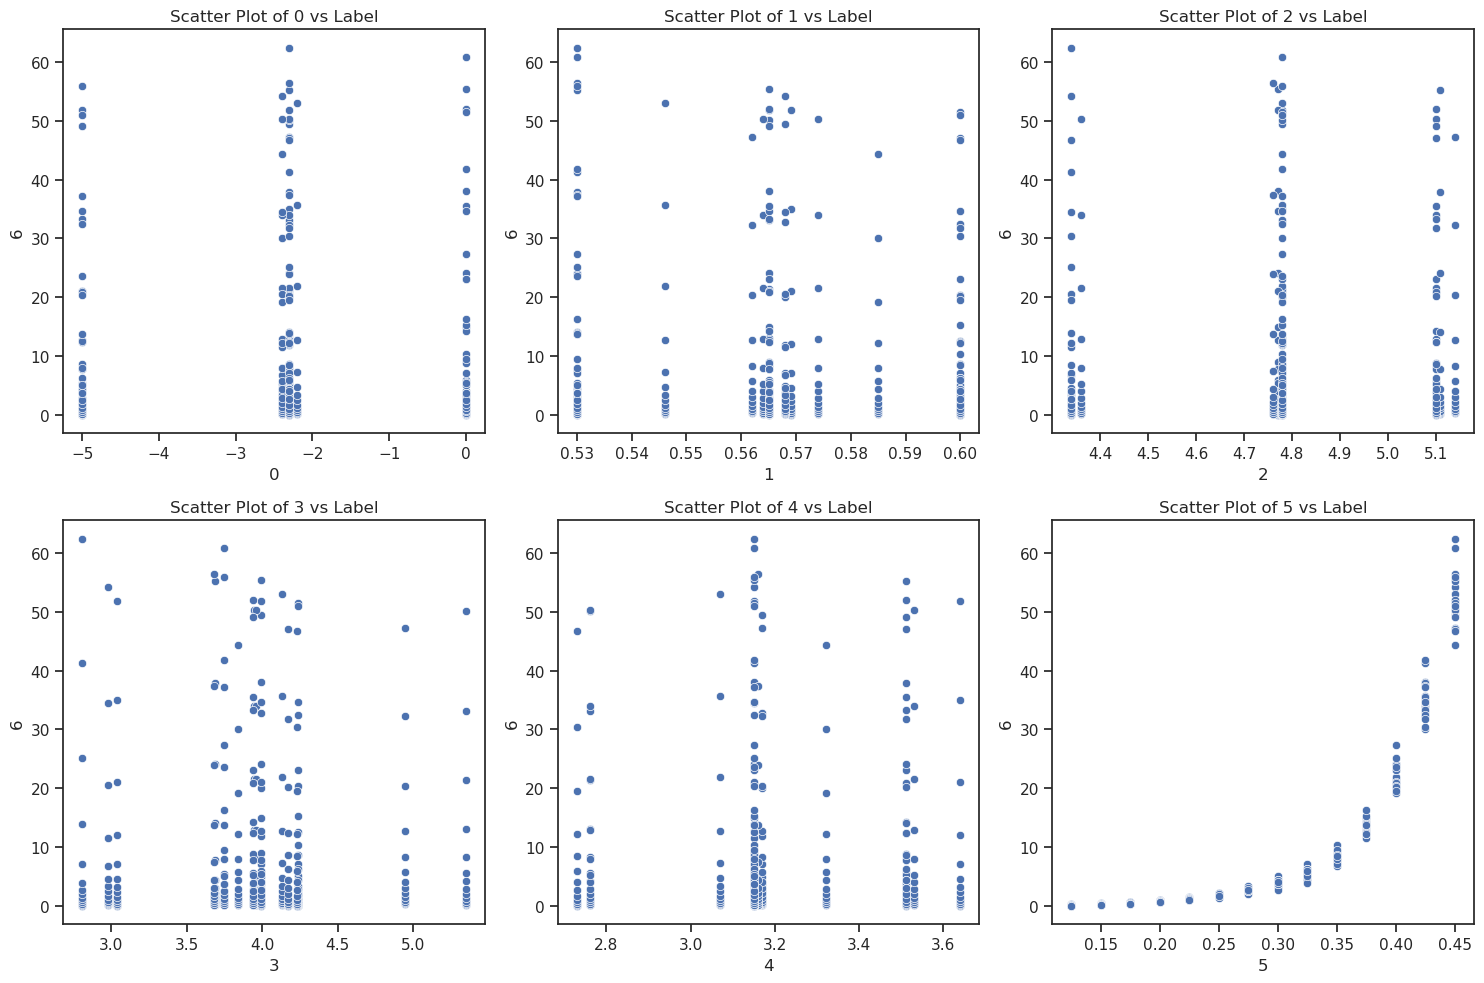

In [72]:
# let's convert the data into a pandas dataframe for analysis and pre-processing
# for visualization we're going to combine features and labels


# convert lists to numpy arrays
features = np.array(features, dtype='float32')
labels = np.array(labels, dtype='float32')


# concatenate
if features.shape[0] == labels.shape[0]:
    # Combine features and labels along the second axis (axis=1) to create the dataset
    dataset = np.concatenate((features, labels.reshape(-1, 1)), axis=1)
else:
    print("Number of samples in features and labels arrays do not match.")


# convert to pandas dataframe
df = pd.DataFrame(dataset)
    
# scatter plots
scatter_plots(df)
    


We can see clearly that the relations are non linear

### Pre-processing

In [24]:
# Let'see if there are NaN values in our datasets

nan_mask = np.isnan(features)
nan_values = features[nan_mask]
print("NaN values in features:", nan_values)

nan_mask = np.isnan(labels)
nan_values = features[nan_mask]
print("NaN values in labels:", nan_values)

NaN values in features: []
NaN values in labels: []


There are no NaN values.

Now, let's make the train/test split and normalize the features.

In [28]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a name="5"></a>
## <b> <font color='#21618C'> 5. Build, compile and train the model </font> </color>


In [31]:
input_dim = X_train.shape[1]
input_dim

6

In [58]:
# build the model
def build_model(input_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
    # Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    
    # Compile model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

    return model

In [59]:
model = build_model(input_dim)

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               896       
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# let's train the model


# Early Stopping Callback
callbacks = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=32, 
                    verbose=0, callbacks=callbacks)

<a name="6"></a>
## <b> <font color='#21618C'> 6. Model Evaluation </font> </color>


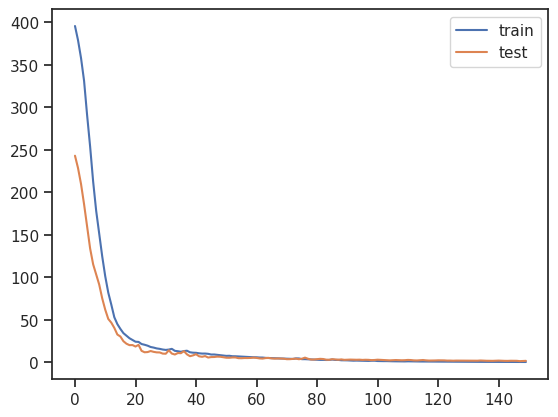

In [71]:
# let's plot training and validation loss

history_plot(history)


In [63]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.8987


1.8986903429031372